# Ambiguity Measure Tutorial

This tutorial shows how use the ambiguity measure module from the OpenDR toolkit.
This colab is adapted from the [Socratic Models: Robot Pick & Place colab](https://colab.research.google.com/drive/1jAyhumd7DTxJB2oZufob9crVxETAEKbV?usp=sharing).

## Setup

First make sure that hardware acceleration is enabled (Edit -> Notebook settings -> Hardware accelerator -> GPU).

Next, we need to install a number of dependencies and download some assets.
Finally, we print some info on the GPU in order to ensure that it is available:

In [22]:
#@markdown

!pip install ftfy regex tqdm fvcore imageio==2.4.1 imageio-ffmpeg==0.4.5
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet moviepy
!pip install flax
!pip install openai
!pip install easydict
# !pip install tensorflow==2.7.0  # If error: UNIMPLEMENTED: DNN library is not found.

import collections
import datetime
import os
import random
import threading
import time

import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.metrics import tensorboard
import imageio
import IPython
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt, transforms, cm
from moviepy.editor import ImageSequenceClip
import numpy as np
import openai
import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.5"


#Download PyBullet assets.
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

%load_ext tensorboard

# Show useful GPU info.
!nvidia-smi

# Show if JAX is using GPU.
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v7iq_7il
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-v7iq_7il
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mon Nov 28 17:54:20 2022       
+--------------

In [23]:
#@markdown Then we set some global constants, such as pick and place objects, colors, workspace bounds.

ALL_COLORS = {"red", "blue", "green"}
SEEN_COLORS = set.union({"yellow", "brown", "gray", "cyan"}, ALL_COLORS)
UNSEEN_COLORS = set.union({"orange", "purple", "pink", "white"}, ALL_COLORS)

COLORS = {
  'blue':   (78/255,  121/255, 167/255, 255/255),
  'red':    (255/255,  87/255,  89/255, 255/255),
  'green':  (89/255,  169/255,  79/255, 255/255),
  'orange': (242/255, 142/255,  43/255, 255/255),
  'yellow': (237/255, 201/255,  72/255, 255/255),
  'purple': (176/255, 122/255, 161/255, 255/255),
  'pink':   (255/255, 157/255, 167/255, 255/255),
  'cyan':   (118/255, 183/255, 178/255, 255/255),
  'brown':  (156/255, 117/255,  95/255, 255/255),
  'gray':   (186/255, 176/255, 172/255, 255/255),
  'white':  (255/255, 255/255, 255/255, 255/255),
}

PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[-0.3, 0.3], [-0.8, -0.2], [0, 0.15]])  # (X, Y, Z)

Next, we will define the gripper and environment classes.

In [24]:
#@markdown **Gripper class:** adds a gripper to the robot and runs a parallel thread to simulate single-actuator behavior.

class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = 'robotiq_2f_85/robotiq_2f_85.urdf'
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool.
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.running = True
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while self.running:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      time.sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  def check_grasp(self):
    while self.moving():
      time.sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist

  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

In [25]:
#@markdown **Gym-style environment class:** this initializes a robot overlooking a workspace with objects.

class PickPlaceEnv():

  def __init__(self):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

  def reset(self, config):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Load objects according to config.
    self.config = config
    self.obj_name_to_id = {}
    obj_names = list(self.config['pick']) + list(self.config['place'])
    obj_xyz = np.zeros((0, 3))
    for obj_name in obj_names:
      if ('block' in obj_name) or ('bowl' in obj_name):

        # Get random position 15cm+ from other objects.
        while True:
          rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
          rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
          rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
          if len(obj_xyz) == 0:
            obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
            break
          else:
            nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
            if nn_dist > 0.15:
              obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
              break
        
        object_color = COLORS[obj_name.split(' ')[0]]
        object_type = obj_name.split(' ')[1]
        object_position = rand_xyz.squeeze()
        if object_type == 'block':
          object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
        elif object_type == 'bowl':
          object_position[2] = 0
          object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
        pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
        self.obj_name_to_id[obj_name] = object_id

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
      pybullet.stepSimulation()
    print('Environment reset: done.')
    return self.get_observation()

  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)
  
  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)

  def step(self, action=None):
    """Do pick and place motion primitive."""
    pick_xyz, place_xyz = action['pick'].copy(), action['place'].copy()

    # Set fixed primitive z-heights.
    hover_xyz = pick_xyz.copy() + np.float32([0, 0, 0.2])
    pick_xyz[2] -= 0.02
    pick_xyz[2] = max(pick_xyz[2], 0.03)
    place_xyz[2] = 0.15

    # Move to object.
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
      self.movep(pick_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Pick up object.
    self.gripper.activate()
    for _ in range(240):
      self.step_sim_and_render()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    
    # Move to place location.
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Place down object.
    while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.03):
      place_xyz[2] -= 0.001
      self.movep(place_xyz)
      for _ in range(3):
        self.step_sim_and_render()
    self.gripper.release()
    for _ in range(240):
      self.step_sim_and_render()
    place_xyz[2] = 0.2
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    place_xyz = np.float32([0, -0.5, 0.2])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    # Render current image at 8 FPS.
    if self.sim_step % (1 / (8 * self.dt)) == 0:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    image_size = (240, 240)
    intrinsics = (120., 0, 120., 0, 120., 120., 0, 0, 1)
    color, _, _, _, _ = env.render_image(image_size, intrinsics)
    return color

  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(self.robot_id, linkIndex=i, rgbaColor=rgba_color)      
        pybullet.changeVisualShape(self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def get_camera_image_top(self, 
                           image_size=(240, 240), 
                           intrinsics=(2000., 0, 2000., 0, 2000., 2000., 0, 0, 1),
                           position=(0, -0.5, 5),
                           orientation=(0, np.pi, -np.pi / 2),
                           zrange=(0.01, 1.),
                           set_alpha=True):
    set_alpha and self.set_alpha_transparency(0)
    color, _, _, _, _ = env.render_image_top(image_size, 
                                             intrinsics,
                                             position,
                                             orientation,
                                             zrange)
    set_alpha and self.set_alpha_transparency(1)
    return color

  def render_image_top(self, 
                       image_size=(240, 240), 
                       intrinsics=(2000., 0, 2000., 0, 2000., 2000., 0, 0, 1),
                       position=(0, -0.5, 5),
                       orientation=(0, np.pi, -np.pi / 2),
                       zrange=(0.01, 1.)):

    # Camera parameters.
    orientation = pybullet.getQuaternionFromEuler(orientation)
    noise=True

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_reward(self):
    return 0  # TODO: check did the robot follow text instructions?

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap
    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -0.85, 0.4)
    orientation = (np.pi / 4 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=True

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            'constant', constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap

def xyz_to_pix(position):
  """Convert from 3D position to pixel location on heightmap."""
  u = int(np.round((BOUNDS[1, 1] - position[1]) / PIXEL_SIZE))
  v = int(np.round((position[0] - BOUNDS[0, 0]) / PIXEL_SIZE))
  return (u, v)

Environment reset: done.


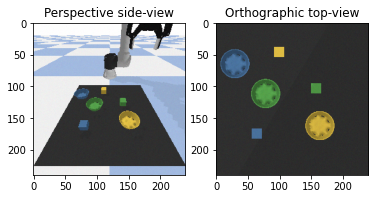

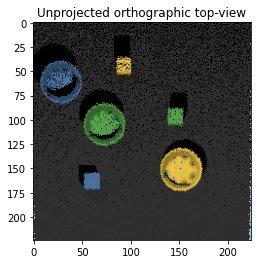

In [26]:
#@markdown Now we can initialize the environment and render images.

if 'env' in locals():
  # Safely exit gripper threading before re-initializing environment.
  env.gripper.running = False
  while env.gripper.constraints_thread.isAlive():
    time.sleep(0.01)
env = PickPlaceEnv()

# Define and reset environment.
config = {'pick':  ['yellow block', 'green block', 'blue block'],
          'place': ['yellow bowl', 'green bowl', 'blue bowl']}

np.random.seed(42)
obs = env.reset(config)

plt.subplot(1, 2, 1)
img = env.get_camera_image()
plt.title('Perspective side-view')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('Orthographic top-view')
plt.imshow(img)
plt.show()

# Note: orthographic cameras do not exist. But we can approximate them by
# projecting a 3D point cloud from an RGB-D camera, then unprojecting that onto
# an orthographic plane. Orthographic views are useful for spatial action maps.
plt.title('Unprojected orthographic top-view')
plt.imshow(obs['image'])
plt.show()

In [27]:
#@markdown Then we create the model (a CLIPort variant).

class ResNetBlock(nn.Module):
  """ResNet pre-Activation block. https://arxiv.org/pdf/1603.05027.pdf"""
  features: int
  stride: int = 1

  def setup(self):
    self.conv0 = nn.Conv(self.features // 4, (1, 1), (self.stride, self.stride))
    self.conv1 = nn.Conv(self.features // 4, (3, 3))
    self.conv2 = nn.Conv(self.features, (1, 1))
    self.conv3 = nn.Conv(self.features, (1, 1), (self.stride, self.stride))

  def __call__(self, x):
    y = self.conv0(nn.relu(x))
    y = self.conv1(nn.relu(y))
    y = self.conv2(nn.relu(y))
    if x.shape != y.shape:
      x = self.conv3(nn.relu(x))
    return x + y


class UpSample(nn.Module):
  """Simple 2D 2x bilinear upsample."""

  def __call__(self, x):
    B, H, W, C = x.shape
    new_shape = (B, H * 2, W * 2, C)
    return jax.image.resize(x, new_shape, 'bilinear')


class ResNet(nn.Module):
  """Hourglass 53-layer ResNet with 8-stride."""
  out_dim: int

  def setup(self):
    self.dense0 = nn.Dense(8)

    self.conv0 = nn.Conv(64, (3, 3), (1, 1))
    self.block0 = ResNetBlock(64)
    self.block1 = ResNetBlock(64)
    self.block2 = ResNetBlock(128, stride=2)
    self.block3 = ResNetBlock(128)
    self.block4 = ResNetBlock(256, stride=2)
    self.block5 = ResNetBlock(256)
    self.block6 = ResNetBlock(512, stride=2)
    self.block7 = ResNetBlock(512)

    self.block8 = ResNetBlock(256)
    self.block9 = ResNetBlock(256)
    self.upsample0 = UpSample()
    self.block10 = ResNetBlock(128)
    self.block11 = ResNetBlock(128)
    self.upsample1 = UpSample()
    self.block12 = ResNetBlock(64)
    self.block13 = ResNetBlock(64)
    self.upsample2 = UpSample()
    self.block14 = ResNetBlock(16)
    self.block15 = ResNetBlock(16)
    self.conv1 = nn.Conv(self.out_dim, (3, 3), (1, 1))

  def __call__(self, x, text):

    # # Project and concatenate CLIP features (early fusion).
    # text = self.dense0(text)
    # text = jnp.expand_dims(text, axis=(1, 2))
    # text = jnp.broadcast_to(text, x.shape[:3] + (8,))
    # x = jnp.concatenate((x, text), axis=-1)

    x = self.conv0(x)
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)

    # Concatenate CLIP features (mid-fusion).
    text = jnp.expand_dims(text, axis=(1, 2))
    text = jnp.broadcast_to(text, x.shape)
    x = jnp.concatenate((x, text), axis=-1)

    x = self.block8(x)
    x = self.block9(x)
    x = self.upsample0(x)
    x = self.block10(x)
    x = self.block11(x)
    x = self.upsample1(x)
    x = self.block12(x)
    x = self.block13(x)
    x = self.upsample2(x)
    x = self.block14(x)
    x = self.block15(x)
    x = self.conv1(x)
    return x


class TransporterNets(nn.Module):
  """TransporterNet with 3 ResNets (translation only)."""

  def setup(self):
    # Picking affordances.
    self.pick_net = ResNet(1)

    # Pick-conditioned placing affordances.
    self.q_net = ResNet(3)  # Query (crop around pick location).
    self.k_net = ResNet(3)  # Key (place features).
    self.crop_size = 64
    self.crop_conv = nn.Conv(features=1, kernel_size=(self.crop_size, self.crop_size), use_bias=False, dtype=jnp.float32, padding='SAME')

  def __call__(self, x, text, p=None, train=True):
    B, H, W, C = x.shape
    pick_out = self.pick_net(x, text)  # (B, H, W, 1)

    # Get key features.
    k = self.k_net(x, text)

    # Add 0-padding before cropping.
    h = self.crop_size // 2
    x_crop = jnp.pad(x, [(0, 0), (h, h), (h, h), (0, 0)], 'maximum')

    # Get query features and convolve them over key features.
    place_out = jnp.zeros((0, H, W, 1), jnp.float32)
    for b in range(B):

      # Get coordinates at center of crop.
      if p is None:
        pick_out_b = pick_out[b, ...]  # (H, W, 1)
        pick_out_b = pick_out_b.flatten()  # (H * W,)
        amax_i = jnp.argmax(pick_out_b)
        v, u = jnp.unravel_index(amax_i, (H, W))
      else:
        v, u = p[b, :]

      # Get query crop.
      x_crop_b = jax.lax.dynamic_slice(x_crop, (b, v, u, 0), (1, self.crop_size, self.crop_size, x_crop.shape[3]))
      # x_crop_b = x_crop[b:b+1, v:(v + self.crop_size), u:(u + self.crop_size), ...]

      # Convolve q (query) across k (key).
      q = self.q_net(x_crop_b, text[b:b+1, :])  # (1, H, W, 3)
      q = jnp.transpose(q, (1, 2, 3, 0))  # (H, W, 3, 1)
      place_out_b = self.crop_conv.apply({'params': {'kernel': q}}, k[b:b+1, ...])  # (1, H, W, 1)
      scale = 1 / (self.crop_size * self.crop_size)  # For higher softmax temperatures.
      place_out_b *= scale
      place_out = jnp.concatenate((place_out, place_out_b), axis=0)

    return pick_out, place_out


def n_params(params):
  return jnp.sum(jnp.int32([n_params(v) if isinstance(v, dict) or isinstance(v, flax.core.frozen_dict.FrozenDict) else np.prod(v.shape) for v in params.values()]))

In [28]:
#@markdown Define Transporter Nets train and eval functions

@jax.jit
def eval_step(params, batch):
    pick_logits, place_logits = TransporterNets().apply({"params": params}, batch["img"], batch["text"])
    return pick_logits, place_logits

# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, 224), np.linspace(-1, 1, 224), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)

In [29]:
#@markdown Load a pretrained model

 # Create clip model
torch.cuda.set_per_process_memory_fraction(0.9, None)
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.cuda().eval()

# Create dummy tensors for model initialization
rng = jax.random.PRNGKey(0)
rng, key = jax.random.split(rng)
init_img = jnp.ones((4, 224, 224, 5), jnp.float32)
init_text = jnp.ones((4, 512), jnp.float32)
init_pix = jnp.zeros((4, 2), np.int32)
model = TransporterNets()
variables = model.init(key, init_img, init_text, init_pix)
jax.tree_util.tree_map(jnp.shape, variables)

# Initialize model parameters
params = variables["params"]
tx = optax.adam(learning_rate=1e-4)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    tx=tx,
    params=variables["params"],
)

ckpt_path = f'interactive_n_train500_n_total1000seen-colors_seed2_epochs32_noisy_1000'
if not os.path.exists(ckpt_path):
  !gdown --id 1z3C6bPT3hhRkH20qPrqc_LrCwZjq69GO

restored_state = checkpoints.restore_checkpoint(ckpt_path, target=state)
print('Loaded:', ckpt_path)

Loaded: interactive_n_train500_n_total1000seen-colors_seed2_epochs32_noisy_1000


In [30]:
#@markdown Define ambiguity measure based on persistent topology

"""
Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class UnionFind:

    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def add(self, object, weight):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = weight

    def __contains__(self, object):
        return object in self.parents

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            assert False
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.parents[r] = heaviest


def get(im, p):
    return im[p[0]][p[1]]


def iter_neighbors(p, w, h):
    y, x = p

    # 8-neighborship
    neigh = [(y + j, x + i) for i in [-1, 0, 1] for j in [-1, 0, 1]]
    # 4-neighborship
    # neigh = [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]

    for j, i in neigh:
        if j < 0 or j >= h:
            continue
        if i < 0 or i >= w:
            continue
        if j == y and i == x:
            continue
        yield j, i


def persistence(im):
    h, w = im.shape

    # Get indices orderd by value from high to low
    indices = [(i, j) for i in range(h) for j in range(w)]
    indices.sort(key=lambda p: get(im, p), reverse=True)

    # Maintains the growing sets
    uf = UnionFind()

    groups0 = {}

    def get_comp_birth(p):
        return get(im, uf[p])

    # Process pixels from high to low
    for i, p in enumerate(indices):
        v = get(im, p)
        ni = [uf[q] for q in iter_neighbors(p, w, h) if q in uf]
        nc = sorted([(get_comp_birth(q), q) for q in set(ni)], reverse=True)

        if i == 0:
            groups0[p] = (v, v, None)

        uf.add(p, -i)

        if len(nc) > 0:
            oldp = nc[0][1]
            uf.union(oldp, p)

            # Merge all others with oldp
            for bl, q in nc[1:]:
                if uf[q] not in groups0:
                    # print(i, ": Merge", uf[q], "with", oldp, "via", p)
                    groups0[uf[q]] = (bl, bl - v, p)
                uf.union(oldp, q)

    groups0 = [(k, groups0[k][0], groups0[k][1], groups0[k][2]) for k in groups0]
    groups0.sort(key=lambda g: g[2], reverse=True)

    return groups0


Environment reset: done.


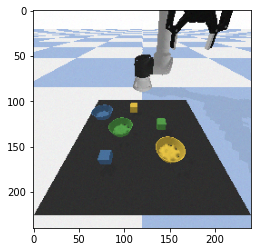

In [31]:
#@markdown Define and reset the environment.
config = {'pick':  ['yellow block', 'green block', 'blue block'],
          'place': ['yellow bowl', 'green bowl', 'blue bowl']}

np.random.seed(42)
obs = env.reset(config)
img = env.get_camera_image()
plt.imshow(img)
plt.show()

Next, we can provide a language command and obtain the ambiguity measure related to that language command.

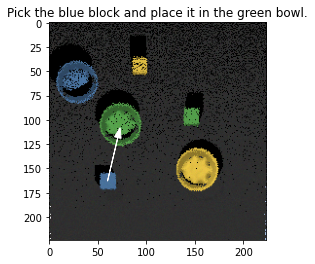

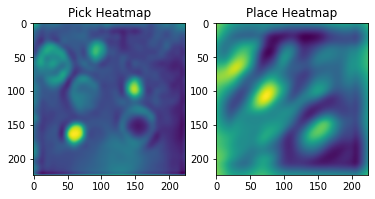

100%|██████████| 44/44 [00:00<00:00, 1147.86it/s]


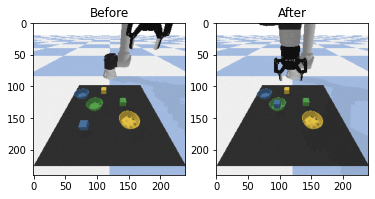

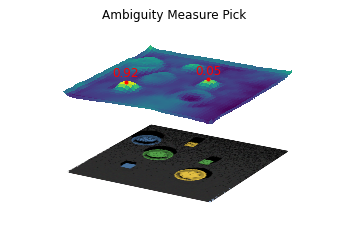

In [32]:
user_input = 'Pick the blue block and place it in the green bowl.'  #@param {type:"string"}

# Show camera image before pick and place.

def run_cliport(obs, text):
  before = env.get_camera_image()
  prev_obs = obs['image'].copy()

  # Tokenize text and get CLIP features.
  text_tokens = clip.tokenize(text).cuda()
  with torch.no_grad():
    text_feats = clip_model.encode_text(text_tokens).float()
  text_feats /= text_feats.norm(dim=-1, keepdim=True)
  text_feats = np.float32(text_feats.cpu())

  # Normalize image and add batch dimension.
  img = obs['image'][None, ...] / 255
  img = np.concatenate((img, coords[None, ...]), axis=3)

  # Run Transporter Nets to get pick and place heatmaps.
  batch = {'img': jnp.float32(img), 'text': jnp.float32(text_feats)}
  pick_map, place_map = eval_step(restored_state.params, batch)
  pick_map, place_map = np.float32(pick_map), np.float32(place_map)

  # Get pick position.
  pick_max = np.argmax(np.float32(pick_map)).squeeze()
  pick_yx = (pick_max // 224, pick_max % 224)
  pick_yx = np.clip(pick_yx, 20, 204)
  pick_xyz = obs['xyzmap'][pick_yx[0], pick_yx[1]]

  # Get place position.
  place_max = np.argmax(np.float32(place_map)).squeeze()
  place_yx = (place_max // 224, place_max % 224)
  place_yx = np.clip(place_yx, 20, 204)
  place_xyz = obs['xyzmap'][place_yx[0], place_yx[1]]

  # Calculate Persistence to find peaks
  pick_map = pick_map.reshape(224, 224)
  place_map = place_map.reshape(224, 224)
  pick_p = persistence(pick_map)
  place_p = persistence(place_map)

  pick_maxima = []
  pick_locs = []
  for i, homclass in enumerate(pick_p):
      p_birth, bl, pers, p_death = homclass
      pick_maxima.append(pick_map[p_birth[0], p_birth[1]])
      pick_locs.append(p_birth)
  place_maxima = []
  place_locs = []
  for i, homclass in enumerate(place_p):
      p_birth, bl, pers, p_death = homclass
      place_maxima.append(place_map[p_birth[0], p_birth[1]])
      place_locs.append(p_birth)
  pick_probs = softmax(np.asarray(pick_maxima))
  place_probs = softmax(np.asarray(place_maxima))

  x_image, y_image = np.mgrid[0:prev_obs.shape[0], 0:prev_obs.shape[1]]

  # Step environment.
  act = {'pick': pick_xyz, 'place': place_xyz}
  obs, _, _, _ = env.step(act)

  # Show pick and place action.
  plt.title(text)
  plt.imshow(prev_obs)
  plt.arrow(pick_yx[1], pick_yx[0], place_yx[1]-pick_yx[1], place_yx[0]-pick_yx[0], color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)
  plt.show()

  # Show debug plots.
  plt.subplot(1, 2, 1)
  plt.title('Pick Heatmap')
  plt.imshow(pick_map.reshape(224, 224))
  plt.subplot(1, 2, 2)
  plt.title('Place Heatmap')
  plt.imshow(place_map.reshape(224, 224))
  plt.show()

  # Show video of environment rollout.
  debug_clip = ImageSequenceClip(env.cache_video, fps=25)
  display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
  env.cache_video = []

  # Show camera image after pick and place.
  plt.subplot(1, 2, 1)
  plt.title('Before')
  plt.imshow(before)
  plt.subplot(1, 2, 2)
  plt.title('After')
  after = env.get_camera_image()
  plt.imshow(after)
  plt.show()
    
  # Show ambiguity measure pick
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.computed_zorder = False

  trans_offset = transforms.offset_copy(ax.transData, fig=fig, y=2, units='dots')
  X, Y = np.mgrid[0:pick_map.shape[0], 0:pick_map.shape[1]]
  Z = pick_map
  ax.set_title("Ambiguity Measure Pick")
  ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False, shade=False, zorder=-1)
  ax.plot_surface(x_image, y_image, np.ones(prev_obs.shape[:2]) * -250, rstride=1, cstride=1, facecolors=prev_obs / 255, shade=False)

  ax.set_zlim(-251, 50)
  ax.view_init(30, 30)
  for loc, value in zip(pick_locs, pick_probs):
      if value > 0.05:
          ax.plot3D([loc[0]], [loc[1]], [value], "r.", zorder=9)
          ax.plot3D([loc[0]], [loc[1]], [-250], "r.", zorder=-2)
          ax.text(
              loc[0], loc[1], value, f"{value:.2f}", zorder=10,
              transform=trans_offset,
              horizontalalignment='center',
              verticalalignment='bottom',
              c="r",
              fontsize="large",
          )
  ax.grid(False)
  ax.set_axis_off()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticklabels([])
  plt.show()


  # return pick_xyz, place_xyz, pick_map, place_map, pick_yx, place_yx
  return obs


# pick_xyz, place_xyz, pick_map, place_map, pick_yx, place_yx = 
obs = run_cliport(obs, user_input)

A visual representation of the ambiguity measure for picking is show in the bottom figure.
Here you will see red values corresponding to significant local maxima ranging from 0 to 1.
A higher value corresponds to higher estimated pick success according to the model.
In case there is not one distinct maximum, the output is considered to be ambiguous.
